In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import operator

In [2]:
def preprocess_image(img,skip_dilate=False):
    img = cv2.GaussianBlur(img.copy(), (15, 15), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    img = cv2.bitwise_not(img, img)
    if not skip_dilate:
        kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]],np.uint8)
        img = cv2.dilate(img, kernel, iterations=1)
    return img

In [3]:
def find_corners_of_largest_polygon(img):
    #Finds the 4 extreme corners of the largest contour in the image.
    contours, h = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find external contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image
    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [4]:
def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

def crop_and_warp(img, points):
    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = points[0], points[1], points[2], points[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])
    # Describe a square with side of the calculated length, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(img, m, (int(side), int(side)))

In [5]:
def split_cells(img):
    squares = []
    side = img.shape[:1][0]/8
    for i in range(8):
        for j in range(8):
            p1 = (i * side, j * side)  # Top left corner of a bounding box
            p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
            squares.append((p1, p2))
    return squares

In [6]:
def display_rects(in_img, rects, colour=255):
    """Displays rectangles on the image."""
    img = in_img.copy()
    for rect in rects:
        img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
    plt_show(img)

In [7]:
def plt_show(img,cmap='gray'):
    plt.imshow(img,cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [11]:
def get_chessboard(filename):
    original_image = cv2.resize(cv2.imread(filename,0),(512,512))
    preprocessed_image = preprocess_image(original_image)
    points = find_corners_of_largest_polygon(preprocessed_image)
    
    # cat bo phan vien cua ban co
    cropped_image = crop_and_warp(original_image,points)
    chieucao, chieurong = cropped_image.shape
    five_percent = chieucao // 100 * 7
    cropped_image = cropped_image[five_percent: chieucao - five_percent, five_percent: chieurong - five_percent]
    
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
    plt.imshow(original_image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.title("Original Image")

    fig.add_subplot(1, 2, 2)
    plt.imshow(cropped_image,cmap='gray')
    plt.xticks([])
    plt.yticks([])
#     plt.axis('off')
    plt.title("Extracted ChessBoard")
    plt.show()
    return cropped_image
    

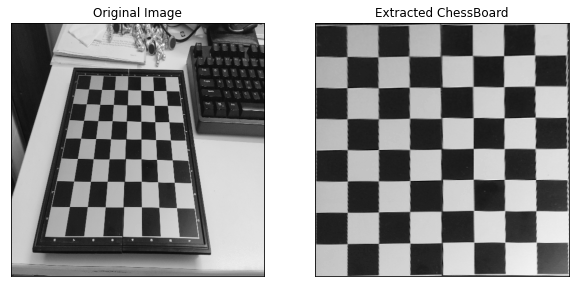

In [12]:
chessboard = get_chessboard('test2.jpg')

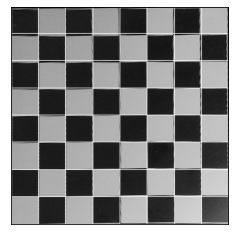

In [13]:
display_rects(chessboard,split_cells(chessboard))

In [14]:
cells = split_cells(chessboard1)
print(len(cells))

64


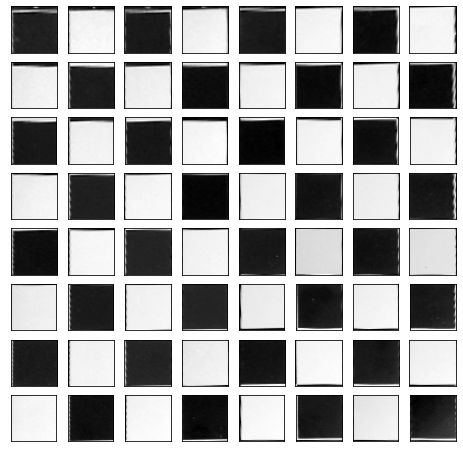

In [15]:
fig = plt.figure(figsize=(8, 8))
columns = 8
rows = 8
cells = split_cells(chessboard1)
for i in range(64):
    cell = cells[i]
    (r1,c1),(r2,c2) = cell
    r1 = int(r1)
    r2 = int(r2)
    c1 = int(c1)
    c2 = int(c2)
    fig.add_subplot(rows, columns, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(chessboard1[r1:r2,c1:c2],cmap='gray')
plt.show()